In [1]:
import os, random, numpy as np, torch
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from utils import *


plt.rcParams.update({
    "font.size": 14,          
    "axes.titlesize": 16,     
    "axes.labelsize": 14,     
    "xtick.labelsize": 12,    
    "ytick.labelsize": 12,
    "legend.fontsize": 12,    
    "figure.titlesize": 18,   
})

# Reproducibility
SEED = 101
rng = np.random.default_rng(SEED)
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", DEVICE)

Device: cpu


## Loading pretrained model

In [2]:
def get_pretrained_sentiment_model(device="cpu"):
    model_name = "distilbert-base-uncased-finetuned-sst-2-english"
    tok = AutoTokenizer.from_pretrained(model_name)
    mdl = AutoModelForSequenceClassification.from_pretrained(model_name).to(device)
    mdl.eval()
    return mdl, tok

model, tokenizer = get_pretrained_sentiment_model(DEVICE)

@torch.inference_mode()
def get_logits_for_texts(model, tokenizer, texts, batch_size=64, device="cpu", max_length=256):
    logits_list = []
    for i in tqdm(range(0, len(texts), batch_size), desc="Batched inference"):
        batch = texts[i:i+batch_size]
        enc = tokenizer(
            batch, return_tensors="pt", padding=True, truncation=True,
            max_length=max_length
        ).to(device)
        out = model(**enc).logits   
        logits_list.append(out.detach().cpu())
    logits = torch.cat(logits_list, dim=0).numpy() 
    return logits


## Building dataset

In [3]:
def sst2_text_pools():
    ds = load_dataset("sst2")
    train = ds["train"]
    pos = [ex["sentence"] for ex in train if ex["label"] == 1]
    neg = [ex["sentence"] for ex in train if ex["label"] == 0]
    rng.shuffle(pos); rng.shuffle(neg)
    return pos, neg

def build_pure_pos_to_neg(length: int, xi: int):
    """[0..xi] positives, [xi+1..n-1] negatives (labels 1 then 0)."""
    pos, neg = sst2_text_pools()
    n1 = xi ; n2 = length - n1
    texts = pos[:n1] + neg[:n2]
    labels = [1]*n1 + [0]*n2
    return texts, labels

def build_mixed_shift(length: int, xi: int, pre_pos_frac=0.6, post_pos_frac=0.4):
    """Pre: 60% pos, Post: 40% pos (default)."""
    pos, neg = sst2_text_pools()
    n_pre = xi ; n_post = length - n_pre
    n_pos_pre = int(round(n_pre * pre_pos_frac))
    n_neg_pre = n_pre - n_pos_pre
    n_pos_post = int(round(n_post * post_pos_frac))
    n_neg_post = n_post - n_pos_post

    pre = list(zip(pos[:n_pos_pre] + neg[:n_neg_pre], [1]*n_pos_pre + [0]*n_neg_pre))
    post = list(zip(pos[n_pos_pre:n_pos_pre+n_pos_post] + neg[n_neg_pre:n_neg_pre+n_neg_post],
                    [1]*n_pos_post + [0]*n_neg_post))
    rng.shuffle(pre); rng.shuffle(post)
    texts, labels = zip(*(pre + post))
    return list(texts), list(labels)


## Setting up pure & mixed shift

In [4]:
n = 1000
xi = 400

# Scenario A: pure pos -> neg
texts_A, labels_A = build_pure_pos_to_neg(n, xi)
logits_A = get_logits_for_texts(model, tokenizer, texts_A, batch_size=64, device=DEVICE) ## estimated model logits

# Scenario B: mixed shift
texts_B, labels_B = build_mixed_shift(n, xi, pre_pos_frac=0.6, post_pos_frac=0.4)
logits_B = get_logits_for_texts(model, tokenizer, texts_B, batch_size=64, device=DEVICE) ## estimated model logits

Batched inference:   0%|          | 0/16 [00:00<?, ?it/s]

Batched inference:   0%|          | 0/16 [00:00<?, ?it/s]

In [5]:
k = 2  # how many before/after to print
start = max(0, xi - k)
end = min(len(texts_A), xi + k + 1)

print(f"\n Showing texts around index {xi} (labels shown too):\n")
for i in range(start, end):
    print(f"[{i+1:>3}] label={labels_A[i]} :: {texts_A[i]}")



 Showing texts around index 400 (labels shown too):

[399] label=1 :: juicy writer 
[400] label=1 :: intricately structured and well-realized drama 
[401] label=0 :: painfully 
[402] label=0 :: than most of jaglom 's self-conscious and gratingly irritating films 
[403] label=0 :: of weird performances and direction 


## CONCH: performance comparison

In [6]:
pvals_A = compute_p_values(logits_A, class_before=1, class_after=0, nperm=400, random_state=SEED)
pvals_B = compute_p_values(logits_B, class_before=1, class_after=0, nperm=400, random_state=SEED)

print("Confidence set (pure): ", confidence_set(pvals_A, 0.05))
print("Confidence set (mixed):", confidence_set(pvals_B, 0.05))

computing CONCH p-values:   0%|          | 0/999 [00:00<?, ?it/s]

computing CONCH p-values:   0%|          | 0/999 [00:00<?, ?it/s]

Confidence set (pure):  [400]
Confidence set (mixed): [327, 329, 330, 331, 332, 333, 334, 336, 337, 338, 339, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361, 362, 363, 364, 365, 366, 367, 368, 369, 370, 371, 372, 373, 374, 375, 376, 377, 378, 379, 380, 381, 382, 383, 384, 385, 386, 387, 388, 389, 390, 391, 392, 393, 394, 395, 396, 397, 398, 399, 400, 401, 402, 403, 404, 405, 406, 407, 408, 409, 410, 411, 412, 413, 414, 415, 416, 417, 418, 419, 420, 421, 422, 423, 424, 425, 426, 427, 428, 429, 430, 431, 432, 433, 434, 435, 436, 437, 438, 439, 440, 441, 442, 443, 444, 445, 446, 447, 448, 449, 450, 451, 452, 453, 454, 455, 456, 457, 458, 459, 460, 461, 462, 463, 464]


/var/folders/0q/1br6tq4j3td60p7x3c_np0xh0000gn/T/ipykernel_60360/4058706563.py:33: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


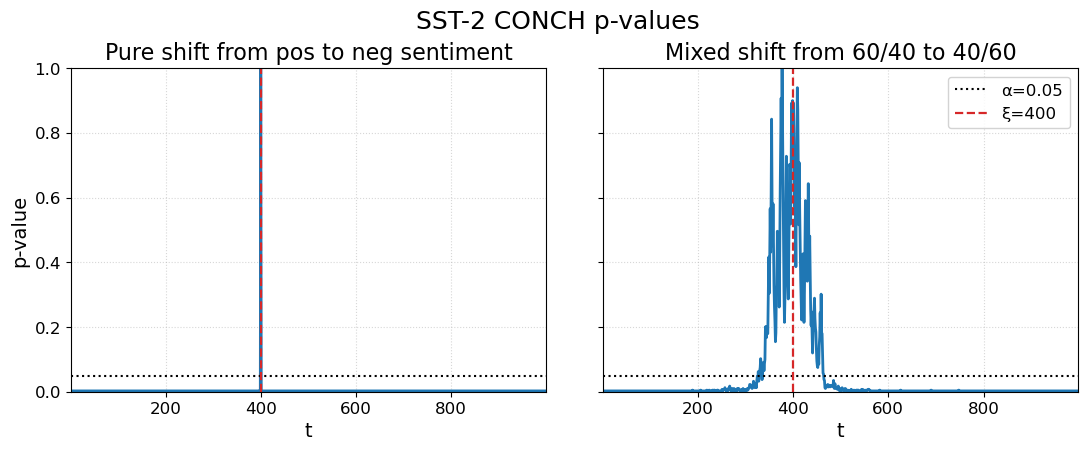

In [7]:
def plot_two_series_pvalues_side_by_side(
    n, xi,
    pvals_A, label_A,
    pvals_B, label_B,
    alpha=0.05,
    title="SST-2 CONCH p-values (two shifts)",
    outfile=None,
):
    tgrid = np.arange(1, n)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 4.2), sharey=True, gridspec_kw={"wspace": 0.12})

    # Panel A
    ax1.plot(tgrid, pvals_A, linewidth=2)
    ax1.axhline(alpha, linestyle=":", color="black", linewidth=1.5)
    ax1.axvline(xi, linestyle="--", color="tab:red", linewidth=1.6)
    ax1.set_xlim(1, n-1); ax1.set_ylim(0, 1)
    ax1.set_xlabel("t"); ax1.set_ylabel("p-value")
    ax1.set_title(label_A)
    ax1.grid(True, linestyle=":", alpha=0.5)

    # Panel B
    ax2.plot(tgrid, pvals_B, linewidth=2, label="_nolegend_")
    ax2.axhline(alpha, linestyle=":", color="black", linewidth=1.5, label=f"α={alpha}")
    ax2.axvline(xi, linestyle="--", color="tab:red", linewidth=1.6, label=f"ξ={xi}")
    ax2.set_xlim(1, n-1)
    ax2.set_xlabel("t"); ax2.set_title(label_B)
    ax2.grid(True, linestyle=":", alpha=0.5)
    
    ax2.legend(loc="upper right", framealpha=0.85)

    fig.suptitle(title, y=1.02)
    plt.tight_layout()

    if outfile:
        os.makedirs(os.path.dirname(outfile), exist_ok=True)
        plt.savefig(outfile, bbox_inches="tight", dpi=200)
    plt.show()

plot_two_series_pvalues_side_by_side(
    n, xi,
    pvals_A, "Pure shift from pos to neg sentiment",
    pvals_B, "Mixed shift from 60/40 to 40/60",
    alpha=0.05,
    title="SST-2 CONCH p-values",
    outfile="../images/sst2_conch_pvalues.pdf",
)
